In [1]:
import torch
from torch import nn
import torchtext
# Should also first install pytorch-transformers (aka transformers)
# See here https://pytorch.org/hub/huggingface_pytorch-transformers/
# and here https://huggingface.co/transformers/

import pandas as pd

from typing import List
from tqdm import tqdm

# TODO: train on same data as WantWords for consistency
# TODO: split data into train/validation sets

In [2]:
# Download vocabulary from S3 and cache.
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    

Using cache found in /home/ubuntu/.cache/torch/hub/huggingface_pytorch-transformers_master


In [3]:
# Download model and configuration from S3 and cache.
bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')    

Using cache found in /home/ubuntu/.cache/torch/hub/huggingface_pytorch-transformers_master


In [4]:
class BertBaseline(nn.Module):
    def __init__(self, embedding_dim, encoder, dropout=0.1):
        super(BertBaseline, self).__init__()
        self.encoder = encoder # the BERT model
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.proj = nn.Linear(768, embedding_dim)
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.xavier_normal_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)
        
    def forward(self, x : torch.Tensor, attention_mask : torch.Tensor):
        out = self.encoder(x, attention_mask)
        encoded = out.get('last_hidden_state')[:,0,:]
        return self.proj(self.dropout(encoded))

In [5]:
# Just a sanity check
test = BertBaseline(300, bert, dropout=0)

In [6]:
text1 = "Somebody once told me the world is gonna roll me"
text2 = "I ain't the sharpest tool in the shed"
text3 = "She was looking kinda dumb with her finger and her thumb"
text4 = "In the shape of an L on her forehead"

text = [text1, text2, text3, text4]
text = sorted(text, key=lambda s: len(s), reverse=True)

In [7]:
tokens = tokenizer(text, return_tensors='pt', padding=True)
sentence_vectors = test(tokens.input_ids, tokens.attention_mask)
sentence_vectors, sentence_vectors.shape

(tensor([[ 1.6856e-01,  7.2188e-01, -7.7491e-02,  ..., -2.1487e+00,
           2.7892e-01,  2.5139e-01],
         [ 7.4780e-01,  8.5869e-01,  2.2149e-01,  ..., -2.0921e+00,
          -2.2286e-01,  6.5578e-01],
         [ 4.7138e-01,  9.4186e-01, -8.1584e-02,  ..., -2.2126e+00,
          -4.6096e-02,  5.4382e-01],
         [ 6.5845e-01,  7.2304e-01, -9.1304e-04,  ..., -2.2000e+00,
           9.5521e-02,  1.8670e-01]], grad_fn=<AddmmBackward>),
 torch.Size([4, 300]))

In [8]:
del test

In [9]:
dict_data_path = 'data/dictionary/reverse-dict-singleton.tsv'

glove_embed_dim = 300 # other options are 100, 200, 300
# glove_embed_path = f'../data/glove_embed/glove.6B.{glove_embed_dim}d.txt'

In [10]:
# Load dictionary data
# Assuming the .tsv files from Prof Oflazer are placed in the data/dictionary folder
dict_data = pd.read_csv(dict_data_path, sep='\t', header=None)

In [11]:
# Load pretrained GloVe embeddings
# Download them from http://nlp.stanford.edu/data/glove.6B.zip
# and place them in the data/glove_embed folder
# WantWords used word2vec, could try that instead

# glove_embed = torchtext.vocab.Vectors(glove_embed_path)
glove_embed = torchtext.vocab.GloVe(name='6B', dim=glove_embed_dim)

In [12]:
# Modified version of dataset class
class DictDataset(torch.utils.data.Dataset):    
    def __init__(self, definitions, embeddings, embedding_dim, tokenizer):
        super(DictDataset, self).__init__()
        self.tokenizer = tokenizer
        
        self.embedding_dim = embedding_dim
        self.embeddings = embeddings
        
        f = lambda x: not torch.all(embeddings.get_vecs_by_tokens([x]) == 0)
        # Filter out words that do not have embeddings
        self.definitions = definitions.loc[definitions[0].apply(f)]
        self.definitions.index = pd.RangeIndex(len(self.definitions.index))
        
    def __getitem__(self, i):
        word, definition = self.definitions.loc[i] # word/definition, in plain text form
        return definition, word
    
    def __len__(self):
        return len(self.definitions)
    
    def collate_fn(self, batch):
        #batch.sort(key=lambda elem: len(elem[0]), reverse=True)
        Xs = self.tokenizer([x for x, _ in batch], return_tensors='pt', padding=True)
        Ys = self.embeddings.get_vecs_by_tokens([y for _, y in batch])
        return (Xs, Ys)

In [13]:
data = DictDataset(dict_data, glove_embed, 300, tokenizer)

batch_size = 96
num_workers = 4
loader = torch.utils.data.DataLoader(data, shuffle=True, 
                batch_size=batch_size, num_workers=num_workers,collate_fn=data.collate_fn)

In [14]:
model = BertBaseline(300, bert, dropout=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [15]:
criterion = nn.CosineSimilarity()

lr = 1e-4
optim = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.1, patience=3, verbose=True)
epochs = 20

In [16]:
inc = 10
losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    with tqdm(total=len(loader)) as pbar:
        for i, (x, y) in enumerate(loader):
            if i % inc == 0:
                pbar.set_description(f'Epoch {epoch+1}, Loss: {train_loss / max(i, 1)}')

            optim.zero_grad()

            x, attention_mask = x.input_ids.to(device), x.attention_mask.to(device)
            y = y.to(device)

            out = model(x, attention_mask)

            loss = 1 - criterion(out, y).sum() / len(x)
            loss.backward()

            optim.step()
            
            train_loss += loss.detach()
            
            pbar.update(1)
            
            del x, y, out, loss
            if i % 20 == 0:
                torch.cuda.empty_cache()
        
        scheduler.step(train_loss)
    losses.append(train_loss)
        

Epoch 20, Loss: 0.15245620906352997: 100%|██████████| 322/322 [03:45<00:00,  1.43it/s]


In [17]:
 torch.save(model, 'bert_baseline1.pt')   

In [130]:
# Informally test the model
model.eval()
x, y = data.collate_fn([("kind of gun", 'n/a')]) 
# there seem to be a lot of gun-related entries in the dictionary...
out = model(x.input_ids.to(device), x.attention_mask.to(device))

# Get most likely words
logits = out.cpu() @ glove_embed.vectors.T
result, indices = torch.sort(logits, descending=True)
indices[0], result[0]

for i in range(50):
    j = indices[0][i]
    print(glove_embed.itos[int(j)])

semiautomatic
firearm
shotguns
handguns
submachine
caliber
handgun
9mm
pistol
ak-47
semi-automatic
.22
rifles
revolvers
chambered
12-gauge
7.62
pistols
.223
rifle
.38
revolver
anti-tank
smoothbore
kalashnikov
musket
ak-47s
gun
m-16
firearms
9-millimeter
carbine
shotgun
autocannon
bushmaster
gas-operated
recoilless
calibre
silencers
x51mm
parabellum
cartridge
.50
launchers
anti-aircraft
ciws
launcher
ar-15
guns
glock


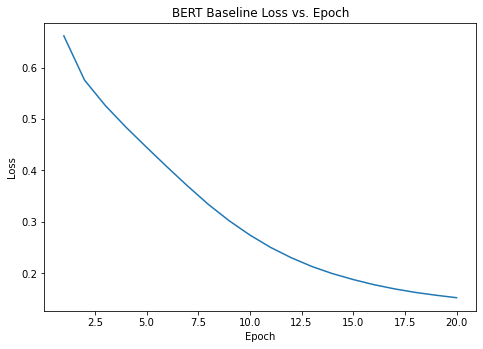

In [118]:
from matplotlib import pyplot as plt
%matplotlib inline

epochs = torch.arange(1, 21)
losses = torch.tensor([0.6615722179412842, 0.5756843686103821, 0.5264729857444763, 0.4842697083950043, 0.44507652521133423, 0.4065987169742584, 0.3691914975643158, 0.3336370289325714, 0.3020656406879425, 0.27435004711151123, 0.2503136992454529, 0.23022735118865967, 0.213185116648674, 0.1992495059967041, 0.18777494132518768, 0.17783407866954803, 0.1696184277534485, 0.1628103107213974, 0.1572929322719574, 0.15245620906352997])

fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(epochs, losses)
axes.set_title("BERT Baseline Loss vs. Epoch")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
fig.show()